<a href="https://colab.research.google.com/github/IrisChan1201/Brain-Tumor-Classification/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic Task**

Implement different learning rates, different data augmentation, different structure of the pretrained model, different trainable network, etc., observe their impact on the classification results, and analyze the reasons.

**Advanced Task**

a.Can segmentation be used to improve classification performance? How can they be used?

b.How can the experience of clinical doctors be integrated into model design?


#Setting up kaggle

In [ ]:
!pip install -q kaggle

# Load Data

The dataset is organized into 2 folders (train, test). Each folder has more four subfolders. These folders have MRIs of respective tumor classes.

https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

In [ ]:
# download dataset for tumor classification
!kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 91% 79.0M/86.8M [00:00<00:00, 221MB/s]
100% 86.8M/86.8M [00:00<00:00, 159MB/s]


In [ ]:
import zipfile

#unzip brain tumor dataset
with zipfile.ZipFile('brain-tumor-classification-mri.zip', 'r') as zf:
  zf.extractall()

test_img_dir = 'Testing'
train_img_dir = 'Training'

# Data Generator

In [ ]:
#@title set epoch, batch_size { display-mode: "form" }

EPOCHS = 10 #@param {type:"slider", min:5, max:10, step:1}
BATCH_SIZE =  10#@param {type:"number"}

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMG_WIDTH, IMG_HEIGHT = 150, 150

train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=8,  #degrees
                   zoom_range=0.1,
                   width_shift_range=0.08,  #percent width
                   height_shift_range=0.08,  #percent height
                   horizontal_flip=False,
                   vertical_flip=False,
                   shear_range=0.02,
                   )

train_generator = train_datagen.flow_from_directory(
                            train_img_dir,
                            target_size=(IMG_WIDTH, IMG_HEIGHT),
                            batch_size=BATCH_SIZE,
                            class_mode='categorical',
                           )

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                                test_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                class_mode='categorical',
                                )

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


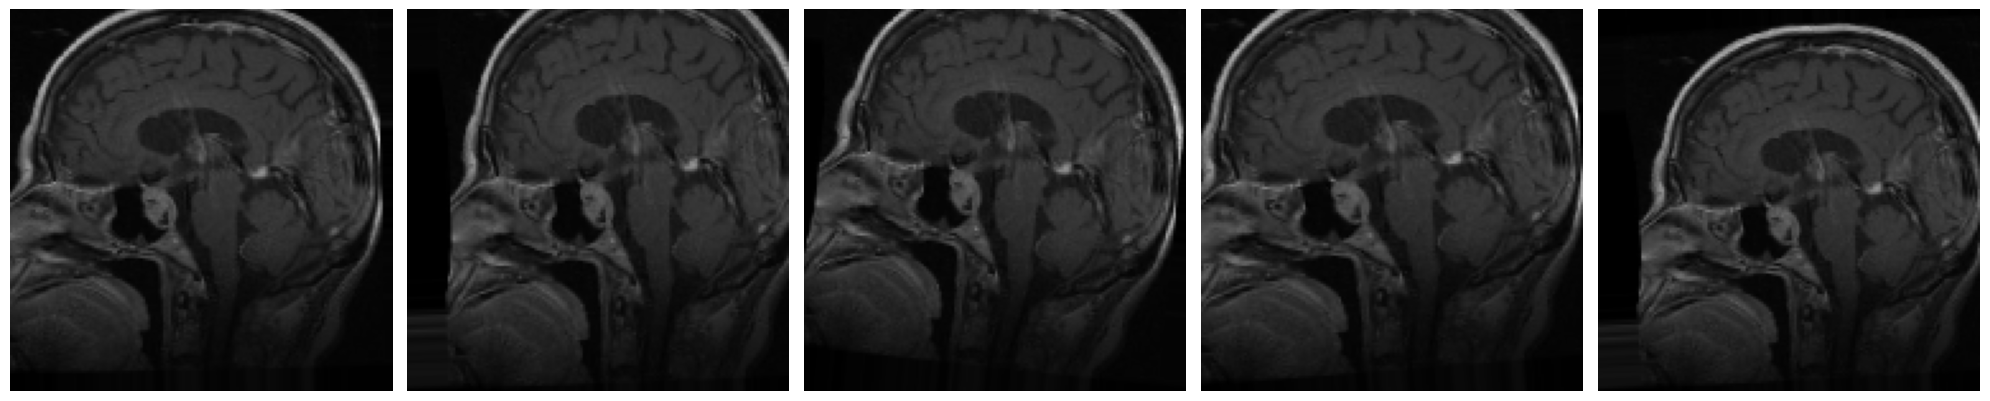

In [ ]:
import matplotlib.pyplot as plt

flow_n = 4 #@param {type:"slider", min:0, max:10, step:1}
idx_m = 3 #@param {type:"slider", min:0, max:9, step:1}

# This function will plot augmented images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show();

plotImages([train_generator[flow_n][0][idx_m] for i in range(5)])

- To resize the image so that all of the images have the same form: width of 150 and height of 150
- ImageDataGenerator augmentation might causes "bleeding" and crop important feature.

# Create Model

In [ ]:
#@title set optimizer and learning_rate{ display-mode: "form" }
from tensorflow.keras.optimizers import Adam, RMSprop

optimizer = "adam" #@param ["adam", "RMSprop"]
learning_rate = 0.0008 #@param {type:"number"}

optimizer = Adam(learning_rate=learning_rate) if optimizer == "adam" \
              else RMSprop(learning_rate=learning_rate)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, concatenate

# image model
image_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# You can also choose other pretrained-models to test the performance
base_model = keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# Freeze the pre-trained layers
base_model.trainable = False
# Add own classification layers
image_model = models.Sequential()
image_model = base_model(image_input)
image_model = Flatten()(image_model)
# Since there are 4 classes in our task
image_model_output=Dense(4, activation='softmax')(image_model)

model = Model(inputs=image_input, outputs=image_model_output)
model.summary()

model.compile(optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['categorical_accuracy'])

234545216/234545216 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 4)                 204804    
                                                                 
Total params: 58536452 (223.30 MB)
Trainable params: 204804 (800.02 KB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________


In [ ]:
import gc
gc.collect()

17846

# Fit Model

In [ ]:
history = model.fit_generator(
                      train_generator,
                      epochs=EPOCHS,
                      validation_data=test_generator,
                      )

Epoch 1/10


<ipython-input-13-acd1894bf29f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


287/287 [==============================] - 29s 101ms/step - loss: 2.2037 - categorical_accuracy: 0.8303 - val_loss: 10.9461 - val_categorical_accuracy: 0.6675
Epoch 2/10
287/287 [==============================] - 29s 99ms/step - loss: 2.1462 - categorical_accuracy: 0.8449 - val_loss: 10.7212 - val_categorical_accuracy: 0.6574
Epoch 3/10
287/287 [==============================] - 27s 94ms/step - loss: 2.3095 - categorical_accuracy: 0.8631 - val_loss: 11.1753 - val_categorical_accuracy: 0.7208
Epoch 4/10
287/287 [==============================] - 27s 94ms/step - loss: 1.6108 - categorical_accuracy: 0.8857 - val_loss: 10.2736 - val_categorical_accuracy: 0.7259
Epoch 5/10
287/287 [==============================] - 27s 94ms/step - loss: 1.8542 - categorical_accuracy: 0.8833 - val_loss: 14.7936 - val_categorical_accuracy: 0.7056
Epoch 6/10
287/287 [==============================] - 27s 95ms/step - loss: 1.6376 - categorical_accuracy: 0.8930 - val_loss: 13.5562 - val_categorical_accuracy: 0.7

# Evaluation

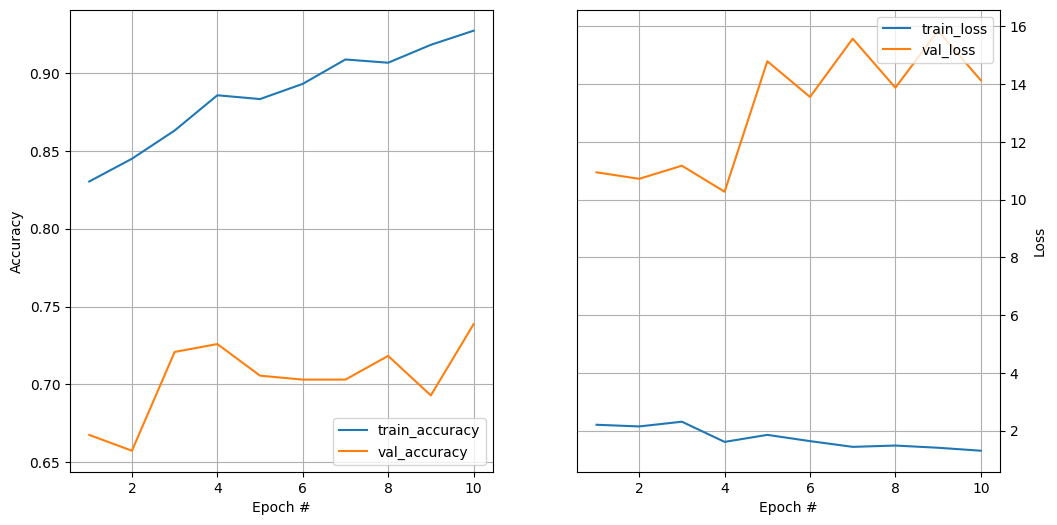

In [ ]:
import numpy as np

acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,2,1)
ax.plot(np.arange(1,len(acc)+1), acc, label='train_accuracy')
ax.plot(np.arange(1,len(val_acc)+1), val_acc, label='val_accuracy')
ax.legend(loc='lower right')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch #')
ax.grid()

ax = fig.add_subplot(1,2,2)
ax.plot(np.arange(1,len(loss)+1), loss, label='train_loss')
ax.plot(np.arange(1,len(val_loss)+1), val_loss, label='val_loss')
ax.legend(loc='upper right')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch #')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.grid();